YF.download() has changed argument auto_adjust default to True


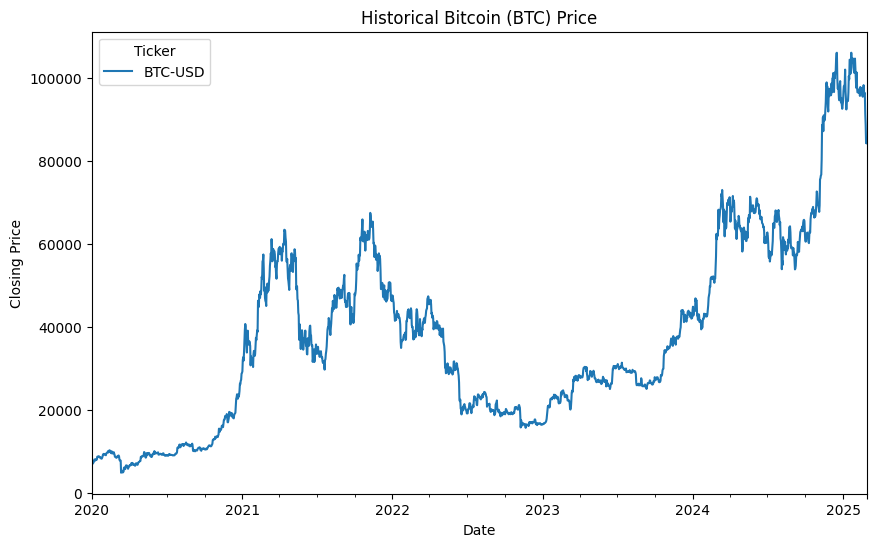

Mean Return per State: State
0    0.029098
1   -0.000054
2   -0.026474
Name: Return, dtype: float64
Transition Matrix:
[[0.3772846  0.2075718  0.4151436 ]
 [0.36253041 0.30900243 0.32846715]
 [0.46327684 0.17655367 0.36016949]]


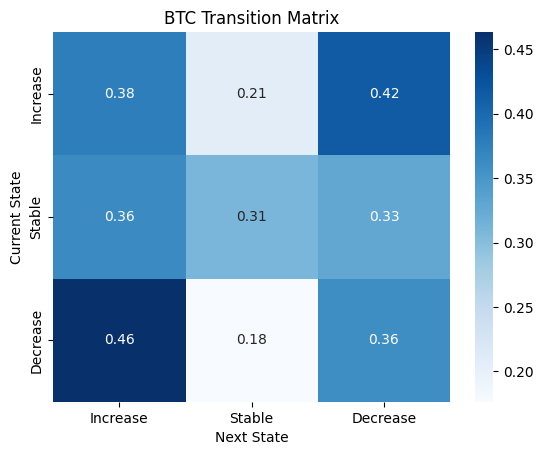

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Retrieve historical BTC data
btc = yf.download("BTC-USD", start="2020-01-01", end="2025-03-01", progress=False)
btc['Close'].plot(figsize=(10, 6))
plt.title("Historical Bitcoin (BTC) Price")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

# Step 2: Calculate daily returns
btc['Return'] = btc['Close'].pct_change()  # Daily return

# Step 3: Discretize returns into states
# Define thresholds to categorize returns into 3 states:
# Increase: Return > 0.5%, Stable: -0.5% <= Return <= 0.5%, Decrease: Return < -0.5%
def discretize_return(r):
    if r > 0.005:
        return 0  # Increase
    elif r < -0.005:
        return 2  # Decrease
    else:
        return 1  # Stable

btc['State'] = btc['Return'].apply(discretize_return)

# Calculate the mean return per state
mean_return = btc.groupby('State')['Return'].mean()
print("Mean Return per State:", mean_return)

# Step 4: Compute the transition matrix
n_states = 3  # Increase, Stable, Decrease
transition_matrix = np.zeros((n_states, n_states))

# Calculate state transitions
for i in range(1, len(btc)):
    current_state = btc['State'].iloc[i-1]
    next_state = btc['State'].iloc[i]
    transition_matrix[current_state, next_state] += 1

# Normalize to obtain probabilities
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# Display the transition matrix
print("Transition Matrix:")
print(transition_matrix)

# Visualize the transition matrix
sns.heatmap(transition_matrix, annot=True, cmap="Blues", xticklabels=["Increase", "Stable", "Decrease"], yticklabels=["Increase", "Stable", "Decrease"])
plt.title("BTC Transition Matrix")
plt.xlabel("Next State")
plt.ylabel("Current State")
plt.show()

C:\Users\antoi\AppData\Local\Temp\ipykernel_31808\2431433830.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  initial_price = int(btc['Close'].iloc[-1])  # Initial BTC price


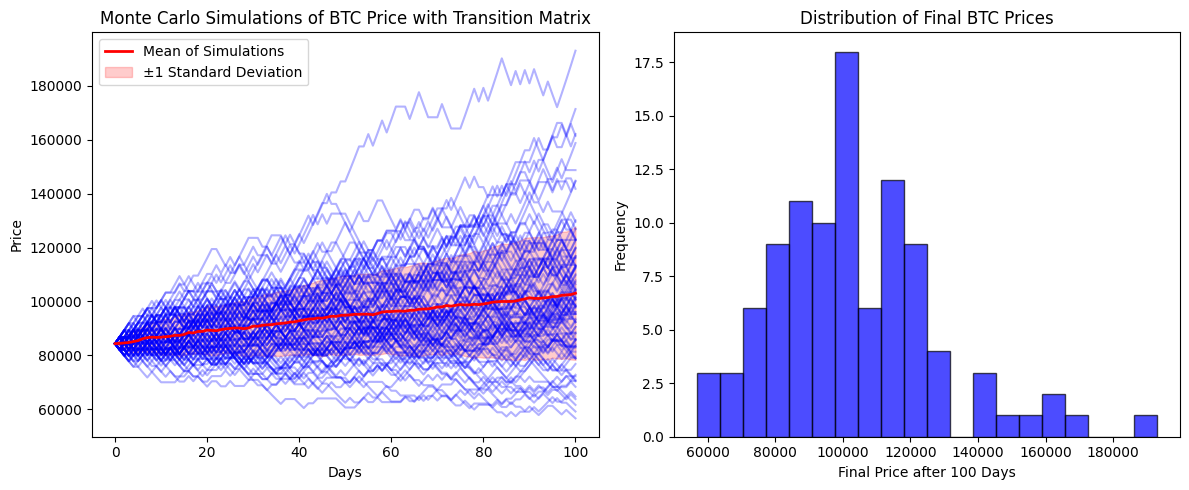

In [2]:
# Simulation Parameters
n_simulations = 100  # Number of simulations
n_days = 100  # Number of simulated days
initial_price = int(btc['Close'].iloc[-1])  # Initial BTC price

# Possible states and their effects on price (in percentage)
state_prices = [1 + mean_return[0], 1 + mean_return[1], 1 + mean_return[2]]  # Increase, Stable, Decrease

# Store trajectories and final prices
all_prices = []
final_prices = []

# Monte Carlo Simulation
for _ in range(n_simulations):
    price = initial_price
    state = np.random.choice([0, 1, 2])  # Random initial state (0: Increase, 1: Stable, 2: Decrease)
    prices = [price]

    for _ in range(n_days):
        price *= state_prices[state]  # Update price based on state
        state = np.random.choice([0, 1, 2], p=transition_matrix[state])  # Transition based on transition matrix
        prices.append(price)

    all_prices.append(prices)  # Store full trajectory
    final_prices.append(prices[-1])  # Store only final price

# Convert to numpy array for easier calculations
all_prices = np.array(all_prices)

# Compute mean and standard deviation at each day
mean_prices = np.mean(all_prices, axis=0)
std_prices = np.std(all_prices, axis=0)

# Plot simulations and mean
plt.figure(figsize=(12, 5))

# Trajectories graph with mean
plt.subplot(1, 2, 1)
for prices in all_prices:
    plt.plot(prices, alpha=0.3, color="blue")  # Plot each simulation

plt.plot(mean_prices, color="red", linewidth=2, label="Mean of Simulations")
plt.fill_between(range(n_days + 1), mean_prices - std_prices, mean_prices + std_prices, color="red", alpha=0.2, label="±1 Standard Deviation")

plt.xlabel("Days")
plt.ylabel("Price")
plt.title("Monte Carlo Simulations of BTC Price with Transition Matrix")
plt.legend()

# Histogram of final prices
plt.subplot(1, 2, 2)
plt.hist(final_prices, bins=20, alpha=0.7, color='b', edgecolor='black')
plt.xlabel("Final Price after 100 Days")
plt.ylabel("Frequency")
plt.title("Distribution of Final BTC Prices")

plt.tight_layout()
plt.show()
